In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Pandemia de COVID-19 en la CDMX desde el año 2020 a 2021.

### **2.1 Descarga y filtrado de datos**
 Descarga los datos de la [pandemia a nivel nacional](https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia), en la sección "Bases de datos históricas Influenza, COVID-19 y otros virus respiratorios", descarga Cierre Datos Abiertos Históricos para los años 2020 y 2021. Descomprime ambas bases, cárgalas en R (Python o el lenguaje de tu preferencia, pero ten en cuenta que tendrás que manejar y/o transformar variables a formato tipo fecha) y en los dos casos:

- Selecciona únicamente las variables necesarias: `CLASIFICACION_FINAL`, `ENTIDAD_RES`, `FECHA_SINTOMAS`, `TIPO_PACIENTE`, `FECHA_DEF` y `EDAD`.
- Filtra los casos positivos a COVID-19 (`CLASIFICACION_FINAL` con valores 1, 2 y 3) para las personas que residen en la CDMX.
- Concatena ambas bases de datos para tener una única base de datos con las seis variables de interés para 2020 y 2021.

In [2]:
cols = ["CLASIFICACION_FINAL", "ENTIDAD_RES", "FECHA_SINTOMAS", "TIPO_PACIENTE", "FECHA_DEF", "EDAD"]

df_2020 = pd.read_csv("Datasets/COVID19MEXICO2020.csv", delimiter=",", usecols=cols)
df_2021 = pd.read_csv("Datasets/COVID19MEXICO2021.csv", delimiter=",", usecols=cols)

# Filtrar casos positivos (CLASIFICACION_FINAL en 1, 2 o 3) y residentes de CDMX (ENTIDAD_RES == 9)
df_2020 = df_2020[df_2020["CLASIFICACION_FINAL"].isin([1, 2, 3]) & (df_2020["ENTIDAD_RES"] == 9)]
df_2021 = df_2021[df_2021["CLASIFICACION_FINAL"].isin([1, 2, 3]) & (df_2021["ENTIDAD_RES"] == 9)]

df_total = pd.concat([df_2020, df_2021], ignore_index=True)

# Convertir columnas de fechas a tipo datetime
df_total["FECHA_SINTOMAS"] = pd.to_datetime(df_total["FECHA_SINTOMAS"], format="%Y-%m-%d", errors="coerce")
df_total["FECHA_DEF"] = pd.to_datetime(df_total["FECHA_DEF"], format="%Y-%m-%d", errors="coerce")

df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025436 entries, 0 to 1025435
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   ENTIDAD_RES          1025436 non-null  int64         
 1   TIPO_PACIENTE        1025436 non-null  int64         
 2   FECHA_SINTOMAS       1025436 non-null  datetime64[ns]
 3   FECHA_DEF            40873 non-null    datetime64[ns]
 4   EDAD                 1025436 non-null  int64         
 5   CLASIFICACION_FINAL  1025436 non-null  int64         
dtypes: datetime64[ns](2), int64(4)
memory usage: 46.9 MB


In [3]:
df_total.head()

,ENTIDAD_RES,TIPO_PACIENTE,FECHA_SINTOMAS,FECHA_DEF,EDAD,CLASIFICACION_FINAL
0,9,1,2020-09-23,NaT,67,3
1,9,1,2020-12-18,NaT,62,3
2,9,1,2020-04-20,NaT,45,3
3,9,1,2020-10-06,NaT,38,1
4,9,1,2020-09-03,NaT,26,3


In [4]:
# Guardar la base concatenada en un nuevo archivo CSV
df_total.to_csv("Datasets/COVID19_CDMX_2020_2021.csv", index=False)

### **2.2 Casos, hospitalizaciones y fallecimientos**

1) A partir de la fecha de inicio de síntomas (variables `FECHA_SINTOMAS`, en formato `as.date()` en R), genera la gráfica del número de casos por mes.
2) Suma 15 días a la fecha de inicio de síntomas (para estimar, aproximadamente, el día en el que se dió la hospitalización) y, considerando la variable `TIPO_PACIENTE`, obtén el número de hospitalizaciones por mes.
3) Calcula el porcentaje de hospitalizaciones por mes con la siguiente fórmula:

$$  \% \text{ de hospitalizaciones } \times \text{ mes} = 100 \times \frac{\text{hospitalizados (de los infectados)} \times \text{mes}}{\text{infectados de COVID-19} \times \text{mes}}$$

genera una serie de tiempo con esta información, donde el eje $x$ representa el mes y el eje $y$ el porcentaje de hospitalizados.

4) Realiza el mismo análisis para las defunciones. En este caso, utiliza la variable de `FECHA_DEF`, sin necesidad de estimación. Observa que cuando no hubo defunción, la base de datos registra 9999-99-99.
5) Observa las tres gráficas obtenidas y describe lo que observas.

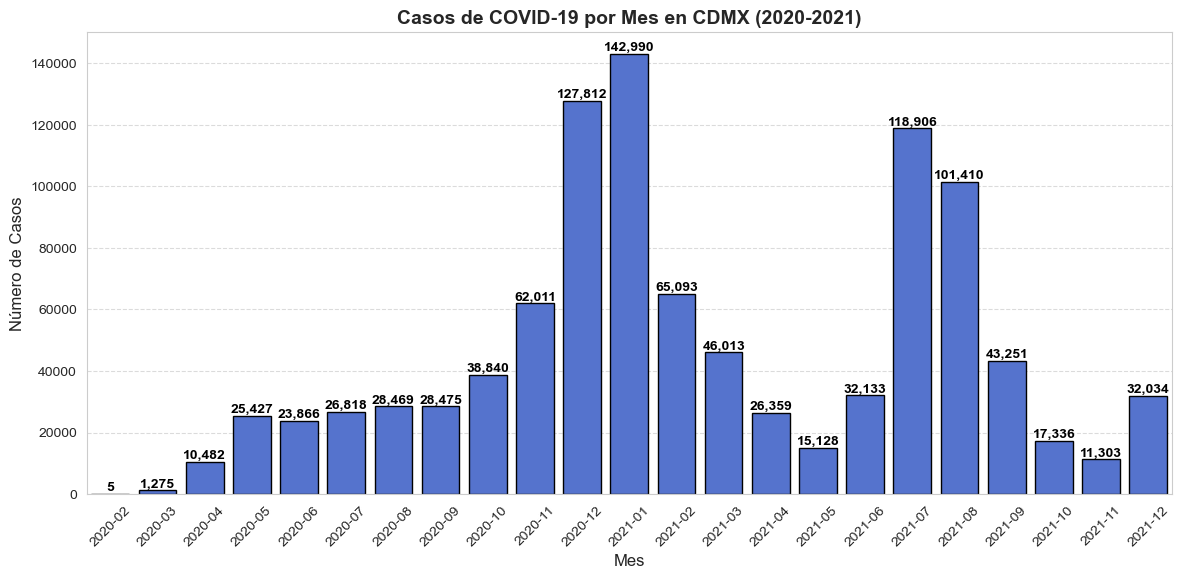

In [5]:
# Agrupar casos por mes
df_total["AM_C"] = df_total["FECHA_SINTOMAS"].dt.to_period("M")  # Extraer año y mes
casos_por_mes = df_total["AM_C"].value_counts().sort_index()  # Contar casos por mes

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=casos_por_mes.index.astype(str), y=casos_por_mes.values, color="royalblue", edgecolor="black")

# Personalizar la gráfica
plt.title("Casos de COVID-19 por Mes en CDMX (2020-2021)", fontsize=14, fontweight="bold")
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotar etiquetas del eje X
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Agregar etiquetas con valores en cada barra
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")

plt.show()

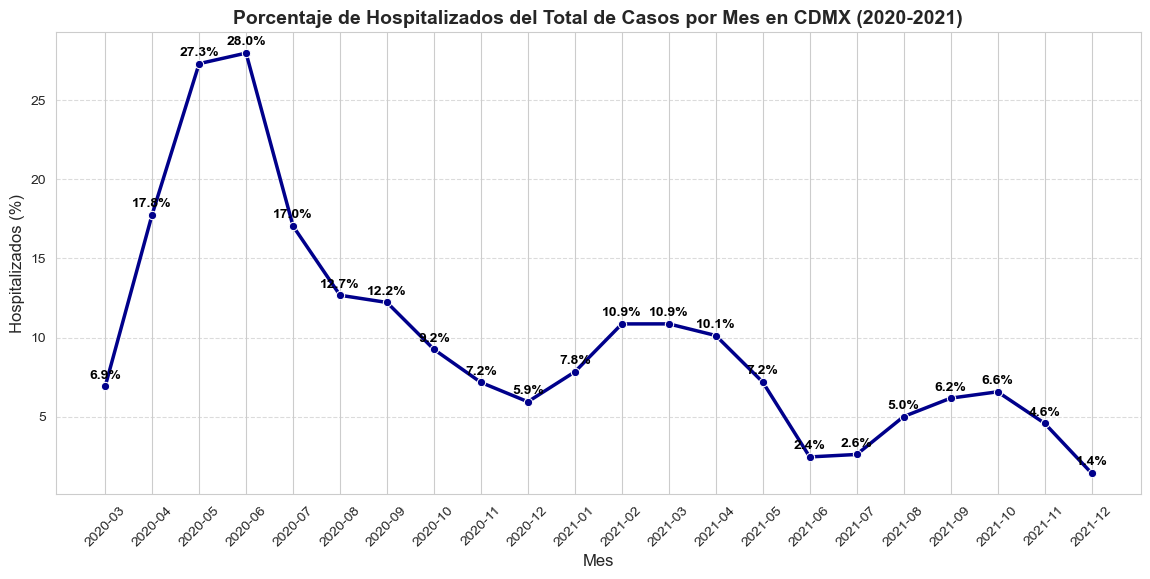

In [6]:
df_total["FECHA_HOSPITALIZACION"] = pd.NaT  

# Sumar 15 días a los casos hospitalizados (TIPO_PACIENTE = 2)
df_total.loc[df_total["TIPO_PACIENTE"] == 2, "FECHA_HOSPITALIZACION"] = df_total["FECHA_SINTOMAS"] + pd.Timedelta(days=15)

# Extraer año y mes de la fecha estimada de hospitalización
df_total["AM_H"] = df_total["FECHA_HOSPITALIZACION"].dt.to_period("M")

# Contar hospitalizados por mes (TIPO_PACIENTE = 2)
hospitalizados_por_mes = df_total[df_total["TIPO_PACIENTE"] == 2]["AM_H"].value_counts().sort_index()

# Calcular porcentaje de hospitalizados por mes
porcentaje_hospitalizados = (hospitalizados_por_mes / casos_por_mes) * 100
porcentaje_hospitalizados = porcentaje_hospitalizados[1:-1]

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.lineplot(x=porcentaje_hospitalizados.index.astype(str), y=porcentaje_hospitalizados.values, marker="o", color="darkblue", linewidth=2.5)

# Personalizar la gráfica
plt.title("Porcentaje de Hospitalizados del Total de Casos por Mes en CDMX (2020-2021)", fontsize=14, fontweight="bold")
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Hospitalizados (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Agregar etiquetas a cada punto
for i, value in enumerate(porcentaje_hospitalizados.values):
    plt.text(i, value + 0.5, f"{value:.1f}%", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()

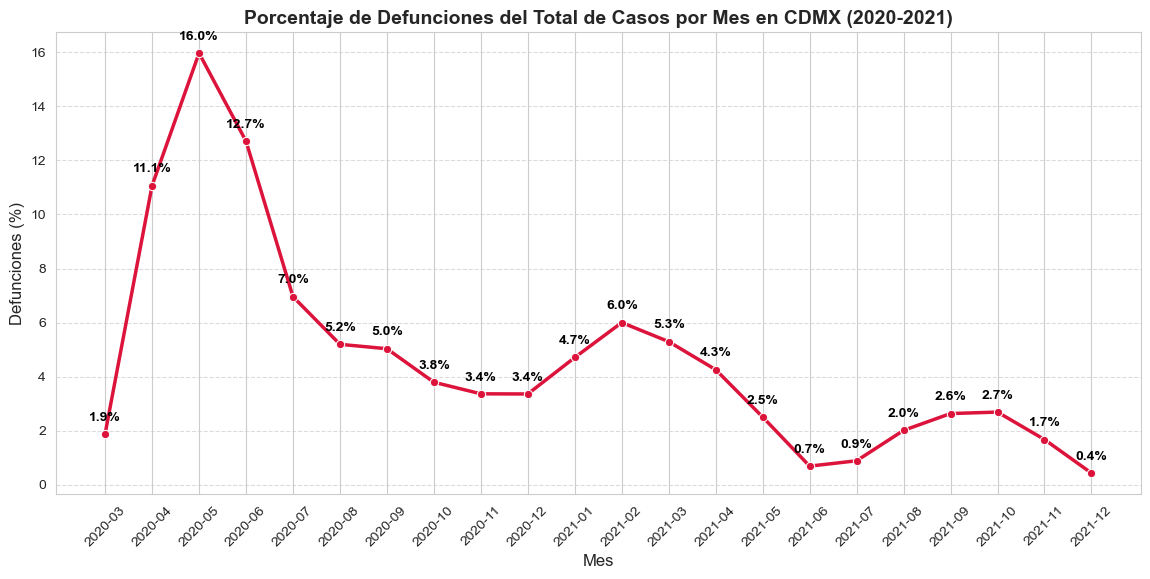

In [7]:
# Extraer año y mes de la fecha de defunción
df_total["AM_DEF"] = df_total["FECHA_DEF"].dt.to_period("M")

# Contar defunciones por mes (solo los registros con fecha de defunción válida)
defunciones_por_mes = df_total["AM_DEF"].value_counts().sort_index()

# Calcular porcentaje de defunciones por mes
porcentaje_defunciones = (defunciones_por_mes / casos_por_mes) * 100
porcentaje_defunciones = porcentaje_defunciones[1:-4]

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.lineplot(x=porcentaje_defunciones.index.astype(str), y=porcentaje_defunciones.values, marker="o", color="crimson", linewidth=2.5)

# Personalizar la gráfica
plt.title("Porcentaje de Defunciones del Total de Casos por Mes en CDMX (2020-2021)", fontsize=14, fontweight="bold")
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Defunciones (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Agregar etiquetas a cada punto
for i, value in enumerate(porcentaje_defunciones.values):
    plt.text(i, value + 0.5, f"{value:.1f}%", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()

### **2.3 Hospitalizaciones y grupos de edad**

1) Define los siguientes grupos de edad:

$$[0,20), [20,40), [40,60), 60 \text{ y mayores.}$$

2) Obtén el porcentaje de hospitalizaciones por mes para cada grupo de edad y grafica las cuatro series de tiempo.
3) Describe lo que observas en la evolución de hospitalizaciones por grupo de edad.

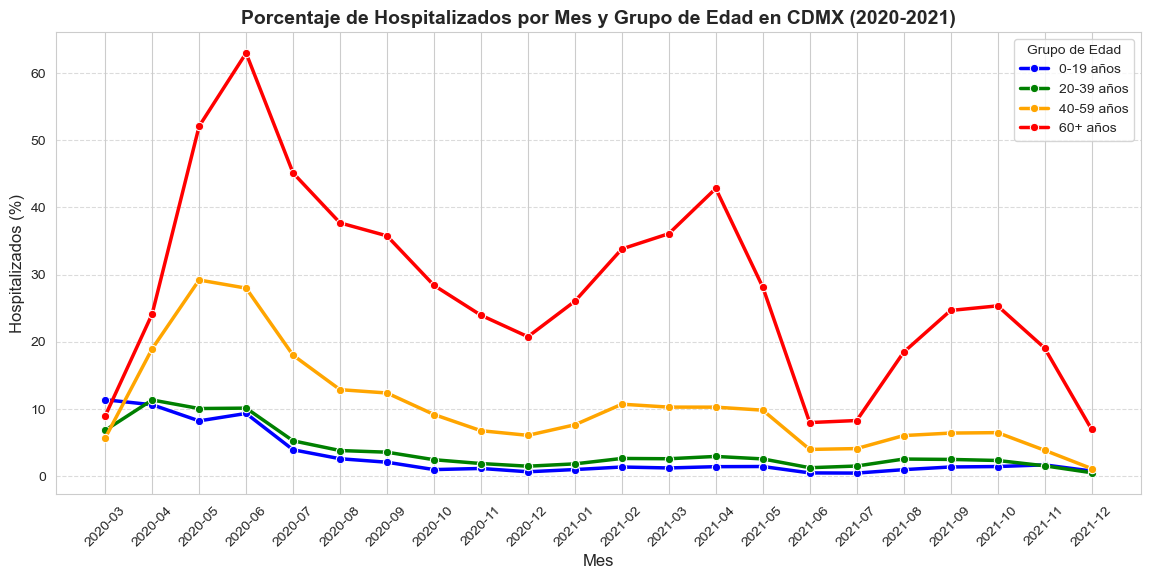

In [8]:
# Definir los grupos de edad
bins = [0, 20, 40, 60, float("inf")]
labels = ["0-19", "20-39", "40-59", "60+"]
df_total["GRUPO_EDAD"] = pd.cut(df_total["EDAD"], bins=bins, labels=labels, right=False)

# Inicializar diccionario para almacenar los porcentajes por grupo de edad
porcentaje_hospitalizados_grupos = {}

# Calcular porcentaje de hospitalización por mes para cada grupo de edad
for grupo in labels:
    # Casos hospitalizados por mes en el grupo
    hospitalizados_grupo = df_total[(df_total["TIPO_PACIENTE"] == 2) & (df_total["GRUPO_EDAD"] == grupo)]["AM_H"].value_counts().sort_index()
    # Casos totales por mes en el grupo
    casos_grupo = df_total[df_total["GRUPO_EDAD"] == grupo]['AM_C'].value_counts().sort_index()
    # Calcular porcentaje de hospitalización por mes
    porcentaje_hospitalizados_grupos[grupo] = (hospitalizados_grupo / casos_grupo) * 100
    porcentaje_hospitalizados_grupos[grupo] = porcentaje_hospitalizados_grupos[grupo].dropna()

# Crear la figura
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Colores para cada grupo
colores = {"0-19": "blue", "20-39": "green", "40-59": "orange", "60+": "red"}

# Graficar cada serie de tiempo
for grupo, color in colores.items():
    sns.lineplot(x=porcentaje_hospitalizados_grupos[grupo].index.astype(str), 
                 y=porcentaje_hospitalizados_grupos[grupo].values, 
                 marker="o", linewidth=2.5, label=f"{grupo} años", color=color)

# Personalizar la gráfica
plt.title("Porcentaje de Hospitalizados por Mes y Grupo de Edad en CDMX (2020-2021)", fontsize=14, fontweight="bold")
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Hospitalizados (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Grupo de Edad")

plt.show()